In [ ]:
# Create a python dict saved in a file which is keyed on subject ID
# and contains all info in the 3 CSV files (meta files) along 
# with python IDs for the resting state (rest), working memory (nback), and
# emotion (emoid) tasks, if scans are available for those 

In [13]:
# Test integer keys

a = 1111111111111111111111111111111111111111111111 # Unbounded integer
b = 609742584520 # An ID from the dataset
c = int(b)
myDict = {a: 'hello', c: 'goodbye'}
print(myDict.keys())

dict_keys([1111111111111111111111111111111111111111111111, 609742584520])


In [79]:
# Create the dict and read in the 3 files

subjects = {}
badIDs = []
header = 'PythonID,ID,AgeInMonths,Gender,Ethnicity,AgeGroupID,AgeGroupEdge1,AgeGroupEdge2'

def doubleCheck(subjID, meta, field, fieldName):
    if meta[fieldName] != field:
        raise Exception('Wrong {:s} for subject {:d} (got {:s} and expected {:s})'
                        .format(subjID, fieldName, str(field), str(meta[fieldName])))

def addTaskToSubjects(subjects, fname, task, badIDs):
    with open(fname, 'r') as f:
        first = True
        for line in f:
            line = line.strip()
            
            # Check header
            if first:
                first = False
                if line != header:
                    raise Exception('Unexpected first line')
                continue
            line = line.split(',')
            
            # Check length
            if len(line) != 8:
                raise Exception('Unexpected array length {:d}: {:s}'.format(len(line), ','.join(line)))
                
            try:
                taskID = line[0]
                subjID = int(line[1])
                ageMonths = int(line[2])
                gender = line[3]
                ethnicity = line[4]
                ageGroup = int(line[5])
                ageGroupEdge1 = int(line[6])
                ageGroupEdge2 = int(line[7])
            except Exception as ex:
                print('[task: {:s}] Got exception on line: {:s}'.format(task, ','.join(line)))
                if subjID not in badIDs:
                    badIDs.append(subjID)
                continue
            
            # Check whether we already have the subject
            if subjID in subjects:
                
                # Double check redundant fields
                meta = subjects[subjID]['meta']
                doubleCheck(subjID, meta, ageMonths, 'AgeInMonths')
                doubleCheck(subjID, meta, gender, 'Gender')
                doubleCheck(subjID, meta, ethnicity, 'Ethnicity')
                doubleCheck(subjID, meta, ageGroup, 'AgeGroupID')
                doubleCheck(subjID, meta, ageGroupEdge1, 'AgeGroupEdge1')
                doubleCheck(subjID, meta, ageGroupEdge2, 'AgeGroupEdge2')
                
                # Check whether we already have this task ID
                if task in subjects[subjID]:
                    raise Exception('Duplicate task {:s}'.format(task))
                
                subjects[subjID][task] = taskID
                
            else:
                meta = {
                    'AgeInMonths': ageMonths,
                    'Gender': gender,
                    'Ethnicity': ethnicity,
                    'AgeGroupID': ageGroup,
                    'AgeGroupEdge1': ageGroupEdge1,
                    'AgeGroupEdge2': ageGroupEdge2
                }
                subjects[subjID] = {
                    'meta': meta,
                    task: taskID
                }
                
            
addTaskToSubjects(subjects, '../../rest_fmri_power264_meta.csv', 'rest', badIDs)
addTaskToSubjects(subjects, '../../nback_fmri_power264_meta.csv', 'nback', badIDs)
addTaskToSubjects(subjects, '../../emoid_fmri_power264_meta.csv', 'emoid', badIDs)

[task: nback] Got exception on line: 243,602893715810,99,M,AFRICAN,0,0,
[task: nback] Got exception on line: 631,607030326315,100,F,OTHER/MIXED,0,0,
[task: nback] Got exception on line: 823,608993302629,99,F,CAUCASIAN/WHITE,0,0,
[task: emoid] Got exception on line: 394,607030326315,100,F,OTHER/MIXED,0,0,


In [80]:
print(len(subjects))
print(badIDs)

941
[602893715810, 607030326315, 608993302629]


In [81]:
keys = list(subjects.keys())
print(subjects[keys[800]])

{'meta': {'AgeInMonths': 217, 'Gender': 'F', 'Ethnicity': 'CAUCASIAN/WHITE', 'AgeGroupID': 4, 'AgeGroupEdge1': 216, 'AgeGroupEdge2': 272}, 'rest': '800', 'nback': '827', 'emoid': '592'}


In [82]:
# Check whether we get correct totals for number of subjects in each modality
# Note the 3 bad subjects above (3 nback, 1 emoid overlapping with nback)

rest = 0
nback = 0
emoid = 0

for key in subjects:
    subj = subjects[key]
    if 'rest' in subj:
        rest += 1
    if 'nback' in subj:
        nback += 1
    if 'emoid' in subj:
        emoid += 1

print(rest)
print(nback)
print(emoid)

878
907
679


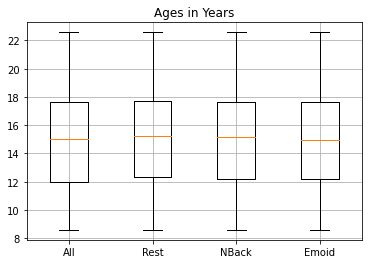

In [83]:
# Check distribution of ages

import numpy as np
import matplotlib.pyplot as plt

ages = np.zeros(len(subjects))
agesRest = np.zeros(878)
agesNBack = np.zeros(907)
agesEmoid = np.zeros(679)
i0 = 0
i1 = 0
i2 = 0
i3 = 0

for _id in subjects:
    subj = subjects[_id]
    age = subj['meta']['AgeInMonths']
    ages[i0] = age
    i0 += 1
    if 'rest' in subj:
        agesRest[i1] = age
        i1 += 1
    if 'nback' in subj:
        agesNBack[i2] = age
        i2 += 1
    if 'emoid' in subj:
        agesEmoid[i3] = age
        i3 += 1
    
plt.boxplot([ages/12, agesRest/12, agesNBack/12, agesEmoid/12], labels=['All', 'Rest', 'NBack', 'Emoid'])
plt.title('Ages in Years')
plt.grid()
plt.show()

In [84]:
# Write subject dictionary to a file

import pickle

with open('../../AllSubjectsMeta.bin', 'wb') as f:
    pickle.dump(subjects, f)
    
print('Complete')

Complete


In [85]:
# Read subjects file and make quick sanity check

subsCheck = None

with open('../../AllSubjectsMeta.bin', 'rb') as f:
    subsCheck = pickle.load(f)
    
#subsCheck[list(subsCheck.keys())[0]]['meta']['AgeInMonths'] = -1
print(subjects == subsCheck)

True


624


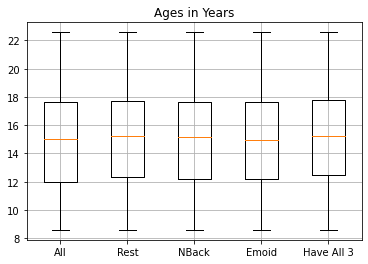

In [86]:
# Find out how many subjects have all of rest, nback, and emoid,
# and plot their age distributions

agesAll3 = []

for _id in subjects:
    sub = subjects[_id]
    if 'rest' in sub and 'nback' in sub and 'emoid' in sub:
        agesAll3.append(sub['meta']['AgeInMonths'])
        
agesAll3 = np.array(agesAll3)
print(len(agesAll3))

plt.boxplot([ages/12, agesRest/12, agesNBack/12, agesEmoid/12, agesAll3/12], 
            labels=['All', 'Rest', 'NBack', 'Emoid', 'Have All 3'])
plt.title('Ages in Years')
plt.grid()
plt.show()

In [87]:
# Make training and test set splits

subsAll3 = []

for _id in subjects:
    sub = subjects[_id]
    if 'rest' in sub and 'nback' in sub and 'emoid' in sub:
        sub['ID'] = _id
        subsAll3.append(sub)
        
print(len(subsAll3))

624


In [90]:
# Write to file

import random

Ntrain = int(len(subsAll3)*3/4)

random.shuffle(subsAll3)

train = subsAll3[0:Ntrain]
test = subsAll3[Ntrain:]

with open('../../Splits/RegressionAllTasks/split3.bin', 'wb') as f:
    pickle.dump({'train': train, 'test': test}, f)

In [95]:
# Check splits

with open('../../Splits/RegressionAllTasks/split3.bin', 'rb') as f:
    d = pickle.load(f)
    train = d['train']
    test = d['test']
    print(len(train))
    print(len(test))
    print(train[0])
    print(test[0])

468
156
{'meta': {'AgeInMonths': 110, 'Gender': 'M', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '765', 'nback': '790', 'emoid': '554', 'ID': 608665596582}
{'meta': {'AgeInMonths': 154, 'Gender': 'M', 'Ethnicity': 'CAUCASIAN/WHITE', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '659', 'nback': '677', 'emoid': '440', 'ID': 607487055951}
